# Brain MRI Segmentation

In [623]:
import scipy.io
import matplotlib.pyplot as plt
import utils


data = scipy.io.loadmat('Brain.mat')
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

(362, 434, 10)
(362, 434, 10)
5
0


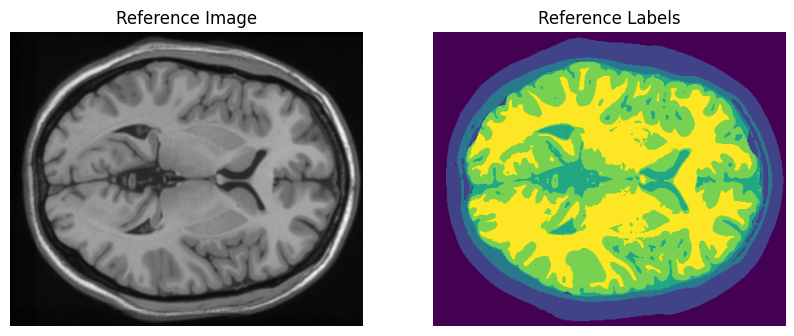

In [624]:
reference_img = mri_stacked[:,:,0]

# Normalize reference_img
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = reference_labels = mri_labels[:,:,0]


utils.plot_images([reference_img,reference_labels], 
            ['Reference Image', 'Reference Labels'],
            ['gray', 'viridis'])

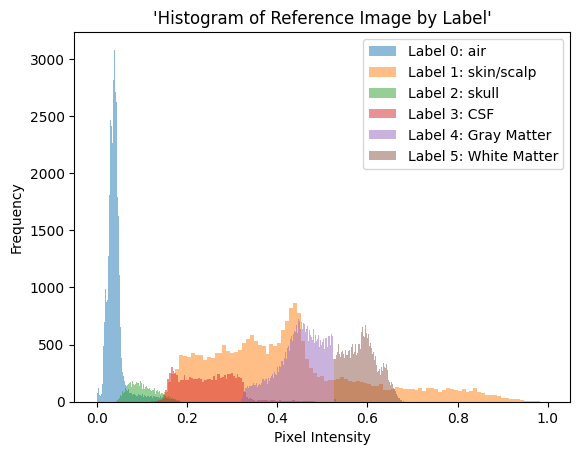

In [625]:
utils.plot_frequencies(reference_img, reference_labels)

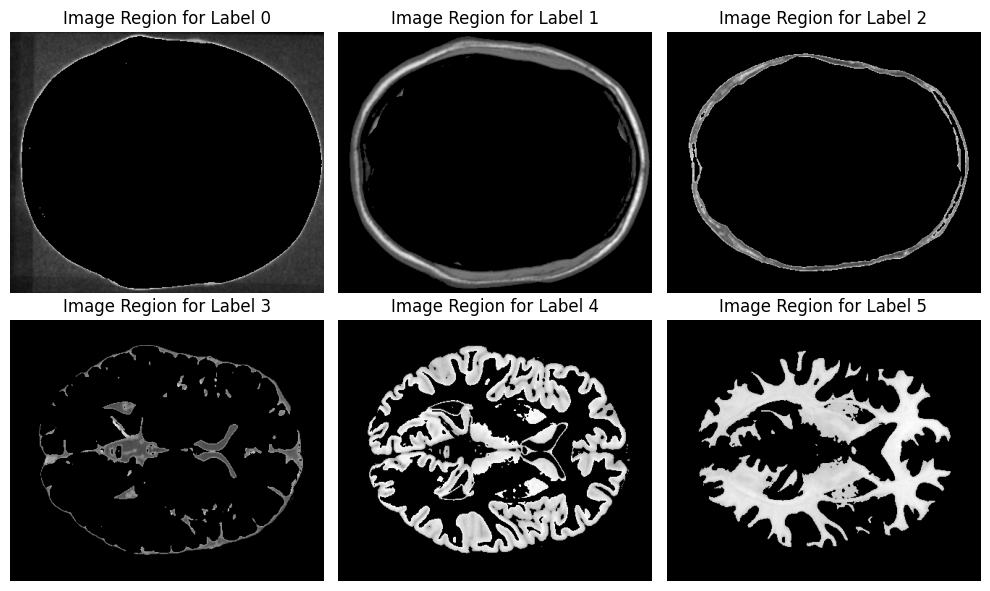

In [626]:
utils.plot_segmented_regions(reference_img, reference_labels)

# Segmentation Algorithm

In [627]:
# Relevant Libraries
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes
import scipy.ndimage as ndimage
from skimage.morphology import convex_hull_image
from sklearn.cluster import KMeans
import numpy as np

from skimage.feature import canny
from skimage.morphology import binary_opening, binary_closing, disk

In [628]:
reference_img = mri_stacked
# Normalize reference_img
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = mri_labels

temporal_masks = {}

def binarizing_cleaning(reference_img):
    # Apply an outsu algorithm to the reference image
    threshold = threshold_otsu(reference_img)
    binary = reference_img > threshold - 0.02

    # Remove the smaller artificts (holes and objects)
    cleaned = remove_small_holes(binary)
    cleaned = remove_small_objects(cleaned, min_size=1000)

    return cleaned

cleaned = binarizing_cleaning(reference_img)

# Plot temporal masks
# utils.plot_images([reference_img, cleaned],[ 'Reference Image', 'Binarized Cleaned Image'], slice_id = 0)

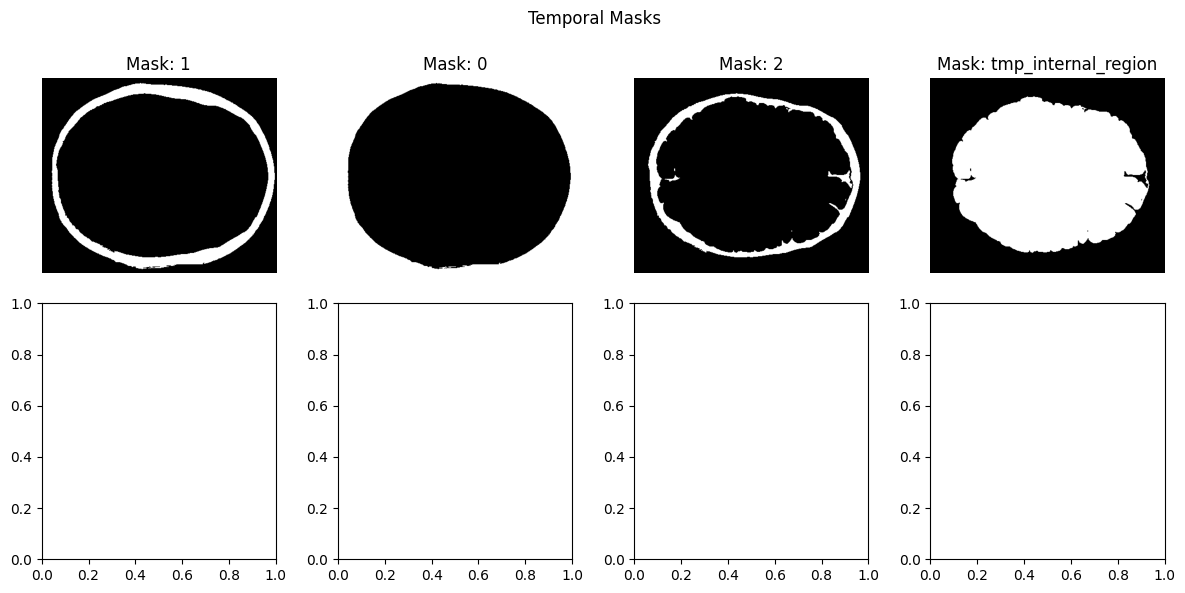

In [629]:
def four_mask_labeling(cleand, temporal_masks):
    # Apply two-pass algorithm to the cleaned image to have preliminary labels
    labels, _ = ndimage.label(cleaned)

    # NOTE: I got 3 labels, but I save only the first label
    # Save the temporal mask label 1
    temporal_masks["1"] = (labels == 1).astype(int)

    # Invert the cleaned image
    inverted = ~cleaned

    # Got the others labels from the inverted image
    # using the same two-pass algorithm
    inverted_labels, num_labels = ndimage.label(inverted)

    # Only consider the two first labels and all the other to zero
    inverted_labels[inverted_labels > 2] = 0

    # Save temporal masks label 0 and 2
    temporal_masks["0"] = (inverted_labels == 1).astype(int)
    temporal_masks["2"] = (inverted_labels == 2).astype(int)

    # Got the tmp internal region by considering all that is
    # not part of the mask 0, 1, 2
    tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
    temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

    return temporal_masks

temporal_masks = four_mask_labeling(cleaned, temporal_masks)

# Plot the temporal_mask in a unique img
# keys = ["0", "1", "2", "tmp_internal_region"]
# utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Four Masks Labeling")

# Plot temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4, slice_id=0)


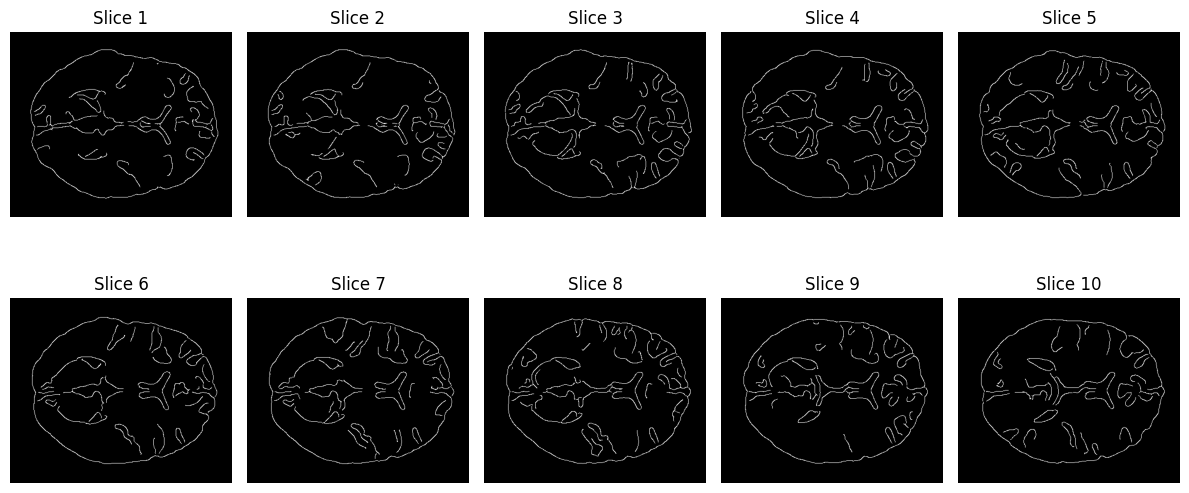

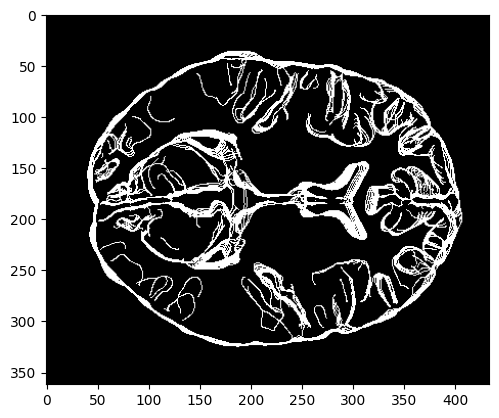

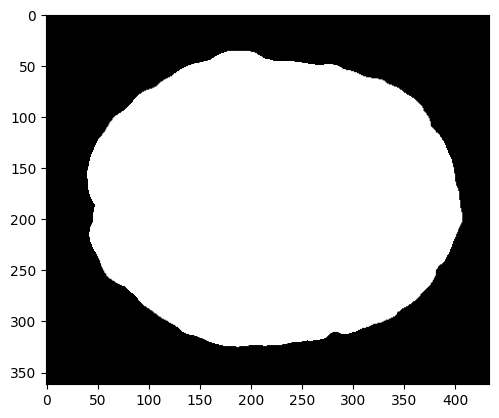

In [630]:
# Dilation of the tmp_internal_region
selem = disk(3)

# Apply canny edge detection to the tmp_internal_region to each slice
edges = np.zeros_like(temporal_masks["tmp_internal_region"])
for i in range(temporal_masks["tmp_internal_region"].shape[2]):

    dilated = ndimage.binary_dilation(temporal_masks["tmp_internal_region"][:,:,i], selem)

    # Apply the tmp_internal_region to the reference image
    internal_region = reference_img[:,:,i] * dilated

    edges[:,:,i] = canny(internal_region, sigma=3)

# Plot the edges
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(edges[:,:,i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Aggregation of the edges
aggregated_edges = np.sum(edges, axis=2) > 0

# Plot the aggregated edges
plt.imshow(aggregated_edges, cmap='gray')
plt.show()

# Fill the holes of the aggregated edges
filled_aggregated_edges = ndimage.binary_fill_holes(aggregated_edges)

# Plot the filled edges
plt.imshow(filled_aggregated_edges, cmap='gray')
plt.show()

# Extend one dimension and repeat the mask to all the slices
filled_aggregated_edges = filled_aggregated_edges[:, :, np.newaxis]

In [631]:
from skimage.feature import canny
# NOTE: convex hull is expensive use edge detection

# NOTE: Here we leverage the thinness of the edges to use the canny edge detection
# while also increase the thickness of the edges by agregating the edges of all the slices

# NOTE: IMPORTANT: Propose a future approach that mix these the edges in a more complex way
# Practically all my experiments are based on the form of the regions rather than the pixels
# intensities consider that when you are writing

def edge_fusion_channel_internal_refinement(temporal_masks, reference_img):

    # Dilation of the tmp_internal_region
    selem = disk(3)

    # Apply canny edge detection to the tmp_internal_region to each slice
    edges = np.zeros_like(temporal_masks["tmp_internal_region"])
    for i in range(temporal_masks["tmp_internal_region"].shape[2]):

        dilated = ndimage.binary_dilation(temporal_masks["tmp_internal_region"][:,:,i], selem)

        # Apply the tmp_internal_region to the reference image
        internal_region = reference_img[:,:,i] * dilated

        edges[:,:,i] = canny(internal_region, sigma=3)

    # Plot the edges
    # fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # for i, ax in enumerate(axes.flat):
    #     ax.imshow(edges[:,:,i], cmap='gray')
    #     ax.set_title(f'Slice {i+1}')
    #     ax.axis('off')

    # plt.tight_layout()
    # plt.show()

    # Aggregation of the edges
    aggregated_edges = np.sum(edges, axis=2) > 0

    # Plot the aggregated edges
    # plt.imshow(aggregated_edges, cmap='gray')
    # plt.show()

    # Fill the holes of the aggregated edges
    filled_aggregated_edges = ndimage.binary_fill_holes(aggregated_edges)

    # Plot the filled edges
    # plt.imshow(filled_aggregated_edges, cmap='gray')
    # plt.show()

    # Extend one dimension and repeat the mask to all the slices
    filled_aggregated_edges = filled_aggregated_edges[:, :, np.newaxis]

    # Save the temp internal region
    temporal_masks["tmp_internal_region"] = filled_aggregated_edges

    # # The cumulativative mask is broadcasted to all the slices
    # # by the new axis added before
    # masked_internal_region = mri_stacked * filled_aggregated_edges

    # plt.imshow(masked_internal_region[:,:,0], cmap='gray')
    # plt.show()
    return filled_aggregated_edges, temporal_masks

# NOTE: we only have one binary mask for every channel
binary_mask, temporal_masks = edge_fusion_channel_internal_refinement(temporal_masks, reference_img)


In [632]:

def agregated_fusion_channel_internal_region(temporal_masks):
    # NOTE: convex hull is expensive to compute
    # Alternative solution: leverage the information of each channel to create a 
    # mask that is the union of all the masks

    # Create a mask that is the union of all the masks
    cumultaive_mask = temporal_masks["tmp_internal_region"].sum(axis=2) > 0
    # NOTE: explain why it doesn't matter to a unique tmp_internal_region for all the channels
    # print(cumultaive_mask.shape)

    # Plot the final mask
    # plt.imshow(cumultaive_mask, cmap='gray')
    # plt.show()

    # # Apply closing to the cumultaive mask
    # cumultaive_mask = binary_closing(cumultaive_mask, disk(3))

    # Fill holes to the cumultaive mask
    cumultaive_mask = ndimage.binary_fill_holes(cumultaive_mask)

    # Dilate a little bit the cumultaive mask
    cumultaive_mask = ndimage.binary_dilation(cumultaive_mask, disk(2))

    # plt.imshow(cumultaive_mask, cmap='gray')
    # plt.show()

    # Extend one dimension and repeat the mask to all the slices
    cumultaive_mask = cumultaive_mask[:, :, np.newaxis]

    temporal_masks["tmp_internal_region"] = cumultaive_mask

    return cumultaive_mask, temporal_masks

    # The cumulativative mask is broadcasted to all the slices
    # by the new axis added before
    # masked_internal_region = mri_stacked * cumultaive_mask

    # plt.imshow(masked_internal_region[:,:,0], cmap='gray')
    # plt.show()

In [633]:
def internal_mask_refinement_convex_hull(temporal_masks):
    # Apply the convex hull to the tmo_internal_region
    binary_mask = convex_hull_image(temporal_masks["tmp_internal_region"])

    # Save the convex hull mask in the temporal masks
    temporal_masks["tmp_internal_region"] = binary_mask.astype(int)

    return binary_mask, temporal_masks

In [634]:
def internal_mask_refinement_morphological(temporal_masks):
    
    # Apply binary opening to the binary image
    binary_mask = binary_closing(temporal_masks["tmp_internal_region"], disk(2))

    # Fill holes in the binary image
    binary_mask = ndimage.binary_fill_holes(binary_mask)

    # Dilate the binary image
    binary_mask = ndimage.binary_dilation(binary_mask, disk(2))

    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

In [635]:
91.02 - 86.45

4.569999999999993

In [636]:
def internal_mask_refinement_edges(temporal_masks, reference_img):

    # Get the edges from masked internal region
    edges = canny(reference_img * temporal_masks["tmp_internal_region"])

    # Dilate the edges
    edges = ndimage.binary_dilation(edges)

    # Fill holes in the edges
    binary_mask = ndimage.binary_fill_holes(edges)

    # remove small objects
    binary_mask = remove_small_objects(binary_mask, min_size=100)

    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

In [637]:
def internal_mask_refinement(temporal_masks, reference_img, method):

    if method == 'convex_hull':
        return internal_mask_refinement_convex_hull(temporal_masks)
    elif method == 'edge_fusion_channel':
        return edge_fusion_channel_internal_refinement(temporal_masks, reference_img)
    elif method == 'internal_region_fusion_channel':
        return agregated_fusion_channel_internal_region(temporal_masks)
        

In [638]:
# # Check each method
# tmp_masks = []
# methods = ['convex_hull', 'morphological', 'edges']

# temporal_masks_copy = temporal_masks.copy()

# for method in methods:
#     binary_mask, _ = internal_mask_refinement(temporal_masks_copy, 
#                                               reference_img,
#                                               method=method)
#     tmp_masks.append(binary_mask)

#     # Plot the temporal masks
#     utils.plot_masks(temporal_masks_copy, rows=2, cols=4)

#     temporal_masks_copy = temporal_masks.copy()


        

# utils.plot_images(
#     tmp_masks,
#     methods
# )

In [639]:
# binary_mask, temporal_masks = internal_mask_refinement(temporal_masks, 
#                                                        reference_img,
#                                                        method='convex_hull')

# keys = ["0", "1", "2", "tmp_internal_region"]
# segemented_img = utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Internal Mask Refinement", isPlot = False)
# utils.plot_images(
#     [binary_mask, reference_img * binary_mask, segemented_img],
#     ['Convex Hull', 'Masked Convex Hull', 'Internal Mask Refinement'],
#     ['gray', 'gray', 'viridis']
# )

In [640]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
arr[1:3]

array([2, 3])

In [641]:
# def weighted_masked_internal_region(masked_internal_region):

#     # Prepare an empty array to hold the weighted averages
#     weighted_averages = np.empty(masked_internal_region.shape)

#     # Prepare the weights
#     weights = utils.create_normal_distribution_mask(length=3, center_index=1, std=1)

#     # Process each set of 3 channels
#     for i in range(10):
#         if i == 0:
#             current_slice = masked_internal_region[:, :, i:i+3]
#         elif i == 9:
#             current_slice = masked_internal_region[:, :, i-2:]
#         else:
#             # Select the current set of 3 channels
#             current_slice = masked_internal_region[:, :, i-1:i+2]
        
#         # Check if the slice is smaller than 3 in the last iteration and adjust weights accordingly
#         if current_slice.shape[2] < 3:
#             current_weights = weights[:current_slice.shape[2]]
#             current_weights /= current_weights.sum()
#         else:
#             current_weights = weights
        
#         # Calculate the weighted average for the current set of 3 channels
#         weighted_avg = np.tensordot(current_slice, current_weights, axes=([2], [0]))
        
#         # Assign the weighted average to the corresponding channels in the output
#         weighted_averages[:, :, i] = weighted_avg


#     # weighted_averages += masked_internal_region

#     # Normalize the weighted averages
#     weighted_averages = (weighted_averages - weighted_averages.min()) / (weighted_averages.max() - weighted_averages.min())

#     return weighted_averages

In [642]:

def weighted_masked_internal_region(masked_internal_region):
    # Prepare an empty array to hold the weighted averages
    weighted_averages = np.empty(masked_internal_region.shape)

    # Process
    for i in range(10):
        # Get current weights
        current_weights = utils.create_normal_distribution_mask(length=10, center_index=i, std=0.5)
        
        # Calculate the weighted average for the current set of 3 channels
        weighted_avg = np.tensordot(masked_internal_region, current_weights, axes=([2], [0]))
        
        # Assign the weighted average to the corresponding channels in the output
        weighted_averages[:, :, i] = weighted_avg

    weighted_averages += masked_internal_region

    # Normalize the weighted averages
    weighted_averages = (weighted_averages - weighted_averages.min()) / (weighted_averages.max() - weighted_averages.min())

    return weighted_averages


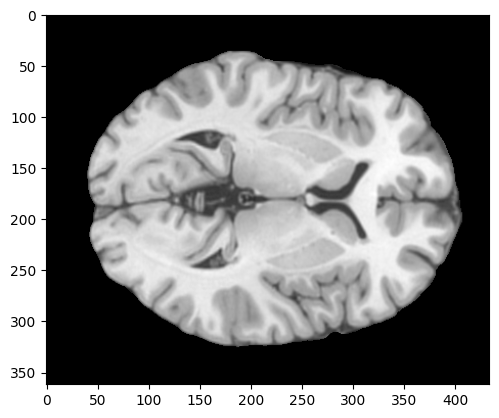

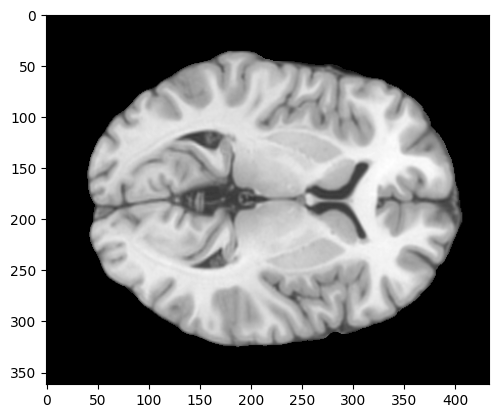

In [643]:
masked_internal_region = reference_img * temporal_masks['tmp_internal_region']

weighted_averages = weighted_masked_internal_region(masked_internal_region)

plt.imshow(masked_internal_region[:,:,0], cmap='gray')
plt.show()

# Plot the weighted averages
plt.imshow(weighted_averages[:,:,0], cmap='gray')
plt.show()

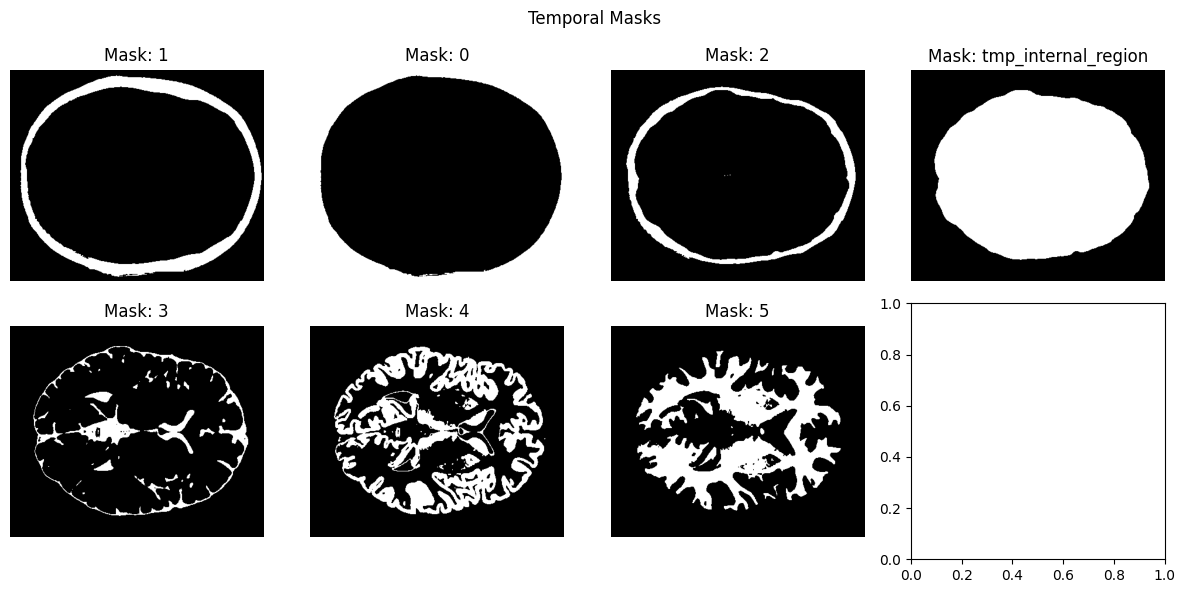

In [644]:
def internal_mask_labeling(temporal_masks, reference_img, weighted_mask = False):
    # Apply the tmp_internal_region to the reference image
    masked_internal_region = reference_img * temporal_masks['tmp_internal_region']

    # Apply the weighted mask to the masked internal region
    if weighted_mask:
        masked_internal_region = weighted_masked_internal_region(masked_internal_region)

    # Apply k-means clustering to the masked internal region
    internal_labels, order = utils.kmeans_segmentation(masked_internal_region, n_clusters=4)

    # Use the order to fit the mask 3, 4, 5
    # NOTE: I don't use order 0 because it corresponds to the external region
    temporal_masks["3"] = (internal_labels == order[1]).astype(int)
    temporal_masks["4"] = (internal_labels == order[2]).astype(int)
    temporal_masks["5"] = (internal_labels == order[3]).astype(int)

    # NOTE: There are certain difference between the convex hull 
    # and the internal region, which consequently affect the
    # k-means clustering, and mask 2. Then, I need to refine
    # the mask 2

    # Refine the mask 2 by considering all the others masks
    tmp_mask = ( temporal_masks["0"] + temporal_masks["1"] +
                temporal_masks["3"] + temporal_masks["4"] +
                temporal_masks["5"] )
    temporal_masks["2"] = (tmp_mask == 0).astype(int)

    return temporal_masks

temporal_masks = internal_mask_labeling(temporal_masks, reference_img)

# Plot the temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4, slice_id=0)

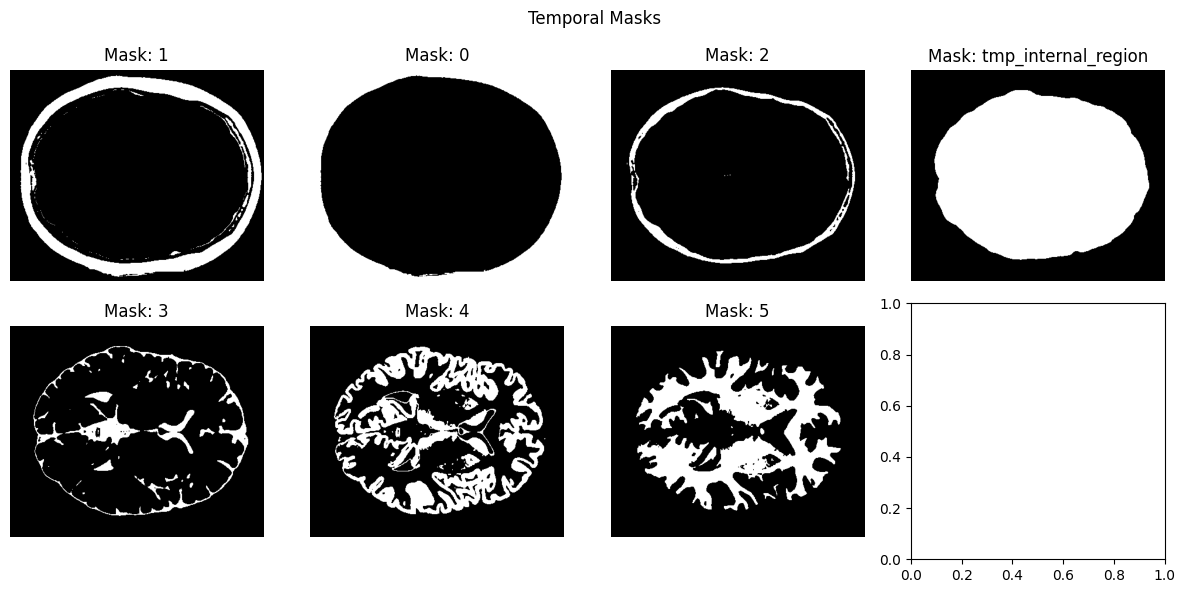

In [645]:
# NOTE: In the ground trues, the mask 1 and 2 have some
# parts in between each other. Then, I need to refine 
# these two masks

def mask_1_2_refinement(reference_img, temporal_masks):
    # Add the mask 1 and 2 in a tmp_mask
    tmp_mask = temporal_masks["1"] + temporal_masks["2"]

    # Apply tmp_mask to the reference image
    tmp_masked = reference_img * tmp_mask

    # Apply outsu algorithm to the masked image
    # NOTE: I add some constant value to the threshold
    # to improve the segmentation
    threshold = threshold_otsu(tmp_masked)
    binary = tmp_masked > threshold - 0.075

    # Add the refined mask 1 and 2 to the temporal masks
    temporal_masks["1"] = binary.astype(int)
    temporal_masks["2"] = tmp_mask - binary
    
    return temporal_masks

temporal_masks = mask_1_2_refinement(reference_img, temporal_masks)

# Plot the temporal masks
utils.plot_masks(temporal_masks, 2, 4, slice_id=0)

Text(0.5, 1.0, 'Final Segmented Image')

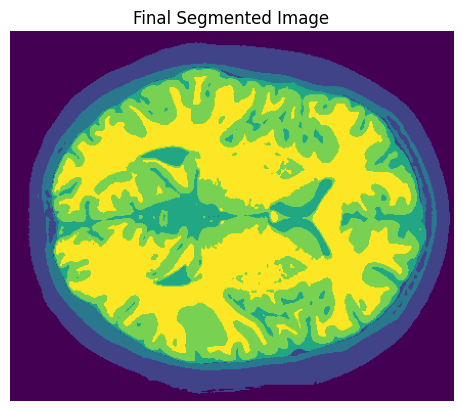

In [646]:
segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=0)

# Plot the final segmented image
plt.imshow(segmented_img)
plt.axis('off')
plt.title('Final Segmented Image')

In [647]:
# Create a function to the whole process
def brain_segmentation(reference_img, temporal_masks, method, weighted_masked = False):

    temporal_masks = {}

    # Binarizing and cleaning the reference image
    cleaned = binarizing_cleaning(reference_img)

    # Apply the two-pass algorithm to the cleaned image
    temporal_masks = four_mask_labeling(cleaned, temporal_masks)

    # Refine the internal region by applying the convex hull
    _, temporal_masks = internal_mask_refinement(temporal_masks, reference_img, method)

    # Apply k-means clustering to the internal region
    temporal_masks = internal_mask_labeling(temporal_masks, reference_img, weighted_masked)

    # Refine the mask 1 and 2
    temporal_masks = mask_1_2_refinement(reference_img, temporal_masks)

    # Get the final segmented image
    # segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks)

    return temporal_masks

In [648]:
temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'convex_hull')

segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=0)

# Show results
metrics, metrics_by_label = utils.calculate_metrics(reference_labels[:,:,0], segmented_img)

print(metrics)
metrics_by_label


{'micro_jaccard': 0.9034, 'micro_dice': 0.9493, 'auprc': 0.9407, 'micro_f1': 0.9493, 'accuracy': 0.9493}


{'jaccard label 0': 0.9513,
 'f1 label 0': 0.975,
 'auprc label 0': 0.9757,
 'jaccard label 1': 0.8571,
 'f1 label 1': 0.9231,
 'auprc label 1': 0.9329,
 'jaccard label 2': 0.9251,
 'f1 label 2': 0.9611,
 'auprc label 2': 0.9626,
 'jaccard label 3': 0.716,
 'f1 label 3': 0.8345,
 'auprc label 3': 0.842,
 'jaccard label 4': 0.8885,
 'f1 label 4': 0.9409,
 'auprc label 4': 0.9554,
 'jaccard label 5': 0.951,
 'f1 label 5': 0.9749,
 'auprc label 5': 0.9755}

In [649]:
# segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'morphological')

# # Show results
# metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

# print(metrics)
# metrics_by_label


In [650]:
# segmented_img, temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'edges')

# # Show results
# metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

# print(metrics)
# metrics_by_label


### Convex Hull Results

In [606]:
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

reference_img = mri_stacked
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = mri_labels   

temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'convex_hull')

for i in range(10):

    segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=i)

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels[:,:,i], segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [607]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.9034,0.9493,0.9407,0.9493,0.9493
1,0.9054,0.9504,0.9442,0.9504,0.9504
2,0.9035,0.9493,0.9445,0.9493,0.9493
3,0.9019,0.9484,0.9437,0.9484,0.9484
4,0.9038,0.9494,0.9443,0.9494,0.9494
5,0.9059,0.9506,0.9446,0.9506,0.9506
6,0.9084,0.9520,0.9459,0.9520,0.9520
7,0.9114,0.9536,0.9467,0.9536,0.9536
8,0.9110,0.9534,0.9444,0.9534,0.9534
9,0.9084,0.9520,0.9412,0.9520,0.9520


In [608]:
print("mean", df_metrics.mean())
print("std", df_metrics.std())

mean micro_jaccard    0.90631
micro_dice       0.95084
auprc            0.94402
micro_f1         0.95084
accuracy         0.95084
dtype: float64
std micro_jaccard    0.003329
micro_dice       0.001822
auprc            0.001844
micro_f1         0.001822
accuracy         0.001822
dtype: float64


In [609]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9513,0.9750,0.9757,0.8571,0.9231,0.9329,0.9251,0.9611,0.9626,0.7160,0.8345,0.8420,0.8885,0.9409,0.9554,0.9510,0.9749,0.9755
1,0.9503,0.9745,0.9751,0.8578,0.9234,0.9341,0.9280,0.9626,0.9640,0.7411,0.8513,0.8586,0.8929,0.9434,0.9574,0.9518,0.9753,0.9759
2,0.9496,0.9742,0.9748,0.8596,0.9245,0.9351,0.9335,0.9656,0.9670,0.7400,0.8506,0.8589,0.8883,0.9408,0.9558,0.9511,0.9749,0.9755
3,0.9489,0.9738,0.9745,0.8598,0.9246,0.9355,0.9319,0.9647,0.9660,0.7362,0.8480,0.8567,0.8868,0.9400,0.9554,0.9489,0.9738,0.9744
4,0.9489,0.9738,0.9745,0.8594,0.9244,0.9351,0.9339,0.9658,0.9670,0.7353,0.8475,0.8558,0.8913,0.9425,0.9573,0.9523,0.9755,0.9761
5,0.9495,0.9741,0.9747,0.8611,0.9254,0.9356,0.9323,0.9650,0.9662,0.7321,0.8454,0.8537,0.8946,0.9444,0.9586,0.9570,0.9780,0.9785
6,0.9507,0.9747,0.9754,0.8629,0.9264,0.9361,0.9311,0.9643,0.9654,0.7437,0.8530,0.8601,0.8960,0.9451,0.9590,0.9586,0.9789,0.9793
7,0.9531,0.9760,0.9765,0.8658,0.9281,0.9372,0.9323,0.9649,0.9660,0.7436,0.8529,0.8594,0.9010,0.9479,0.9610,0.9597,0.9794,0.9798
8,0.9533,0.9761,0.9767,0.8639,0.9270,0.9357,0.9407,0.9694,0.9704,0.7196,0.8370,0.8432,0.9012,0.9480,0.9608,0.9600,0.9796,0.9800
9,0.9533,0.9761,0.9767,0.8525,0.9204,0.9286,0.9451,0.9718,0.9727,0.6992,0.8230,0.8288,0.9011,0.9480,0.9608,0.9590,0.9791,0.9795


### Edge Fusion Chanell Results

In [651]:
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

reference_img = mri_stacked
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = mri_labels   

temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'edge_fusion_channel')

for i in range(10):

    segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=i)

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels[:,:,i], segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [652]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.9081,0.9518,0.9452,0.9518,0.9518
1,0.9086,0.9521,0.9473,0.9521,0.9521
2,0.9077,0.9516,0.9476,0.9516,0.9516
3,0.9049,0.9501,0.9460,0.9501,0.9501
4,0.9073,0.9514,0.9468,0.9514,0.9514
5,0.9090,0.9524,0.9473,0.9524,0.9524
6,0.9122,0.9541,0.9490,0.9541,0.9541
7,0.9152,0.9557,0.9498,0.9557,0.9557
8,0.9157,0.9560,0.9489,0.9560,0.9560
9,0.9149,0.9556,0.9481,0.9556,0.9556


In [654]:
print("mean", df_metrics.mean())
print("std", df_metrics.std())

mean micro_jaccard    0.91036
micro_dice       0.95308
auprc            0.94760
micro_f1         0.95308
accuracy         0.95308
dtype: float64
std micro_jaccard    0.003833
micro_dice       0.002101
auprc            0.001409
micro_f1         0.002101
accuracy         0.002101
dtype: float64


In [655]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9513,0.9750,0.9757,0.8626,0.9262,0.9367,0.9304,0.9640,0.9653,0.7448,0.8537,0.8607,0.8933,0.9436,0.9572,0.9510,0.9749,0.9755
1,0.9503,0.9745,0.9751,0.8630,0.9265,0.9377,0.9281,0.9627,0.9641,0.7641,0.8663,0.8732,0.8961,0.9452,0.9586,0.9500,0.9744,0.9750
2,0.9496,0.9742,0.9748,0.8654,0.9278,0.9391,0.9284,0.9629,0.9645,0.7622,0.8650,0.8731,0.8948,0.9445,0.9583,0.9511,0.9749,0.9755
3,0.9489,0.9738,0.9745,0.8649,0.9276,0.9393,0.9241,0.9606,0.9622,0.7529,0.8590,0.8681,0.8916,0.9427,0.9573,0.9489,0.9738,0.9744
4,0.9489,0.9738,0.9745,0.8676,0.9291,0.9406,0.9197,0.9582,0.9601,0.7559,0.8610,0.8700,0.8969,0.9456,0.9593,0.9523,0.9755,0.9761
5,0.9495,0.9741,0.9747,0.8699,0.9304,0.9417,0.9179,0.9572,0.9593,0.7554,0.8607,0.8700,0.8991,0.9469,0.9603,0.9550,0.9770,0.9775
6,0.9507,0.9747,0.9754,0.8738,0.9327,0.9435,0.9151,0.9557,0.9578,0.7693,0.8696,0.8779,0.9013,0.9481,0.9609,0.9575,0.9783,0.9787
7,0.9531,0.9760,0.9765,0.8803,0.9363,0.9465,0.9097,0.9527,0.9552,0.7704,0.8703,0.8787,0.9057,0.9505,0.9627,0.9585,0.9788,0.9793
8,0.9533,0.9761,0.9767,0.8826,0.9376,0.9477,0.9156,0.9559,0.9585,0.7531,0.8591,0.8680,0.9060,0.9507,0.9626,0.9600,0.9796,0.9800
9,0.9533,0.9761,0.9767,0.8808,0.9366,0.9467,0.9137,0.9549,0.9578,0.7505,0.8575,0.8666,0.9052,0.9502,0.9623,0.9577,0.9784,0.9788


In [657]:
print("mean")
print(df_metrics_by_label.mean())
print("std")
print(df_metrics_by_label.std())

mean
jaccard label 0    0.95089
f1 label 0         0.97483
auprc label 0      0.97546
jaccard label 1    0.87109
f1 label 1         0.93108
auprc label 1      0.94195
jaccard label 2    0.92027
f1 label 2         0.95848
auprc label 2      0.96048
jaccard label 3    0.75786
f1 label 3         0.86222
auprc label 3      0.87063
jaccard label 4    0.89900
f1 label 4         0.94680
auprc label 4      0.95995
jaccard label 5    0.95420
f1 label 5         0.97656
auprc label 5      0.97708
dtype: float64
std
jaccard label 0    0.001782
f1 label 0         0.000931
auprc label 0      0.000895
jaccard label 1    0.007751
f1 label 1         0.004408
auprc label 1      0.003964
jaccard label 2    0.007103
f1 label 2         0.003868
auprc label 2      0.003386
jaccard label 3    0.008352
f1 label 3         0.005405
auprc label 3      0.005371
jaccard label 4    0.005326
f1 label 4         0.002953
auprc label 4      0.002126
jaccard label 5    0.004015
f1 label 5         0.002102
auprc label 5 

### Internal region Fusion Channel Results

In [614]:
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

reference_img = mri_stacked
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = mri_labels   

temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'internal_region_fusion_channel')

for i in range(10):

    segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=i)

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels[:,:,i], segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [615]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.9069,0.9512,0.9452,0.9512,0.9512
1,0.9087,0.9522,0.9478,0.9522,0.9522
2,0.9074,0.9515,0.9482,0.9515,0.9515
3,0.9056,0.9505,0.9469,0.9505,0.9505
4,0.9067,0.9510,0.9466,0.9510,0.9510
5,0.9078,0.9517,0.9465,0.9517,0.9517
6,0.9114,0.9537,0.9485,0.9537,0.9537
7,0.9135,0.9548,0.9486,0.9548,0.9548
8,0.9142,0.9552,0.9478,0.9552,0.9552
9,0.9119,0.9539,0.9460,0.9539,0.9539


In [616]:
print("mean", df_metrics.mean())
print("std", df_metrics.std())

mean micro_jaccard    0.90941
micro_dice       0.95257
auprc            0.94721
micro_f1         0.95257
accuracy         0.95257
dtype: float64
std micro_jaccard    0.003076
micro_dice       0.001687
auprc            0.001143
micro_f1         0.001687
accuracy         0.001687
dtype: float64


In [617]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9513,0.9750,0.9757,0.8683,0.9295,0.9407,0.9104,0.9531,0.9555,0.7600,0.8636,0.8715,0.8916,0.9427,0.9565,0.9432,0.9708,0.9716
1,0.9503,0.9745,0.9751,0.8678,0.9292,0.9410,0.9117,0.9538,0.9561,0.7803,0.8766,0.8836,0.8969,0.9456,0.9587,0.9440,0.9712,0.9720
2,0.9496,0.9742,0.9748,0.8694,0.9302,0.9419,0.9174,0.9569,0.9593,0.7796,0.8761,0.8840,0.8942,0.9442,0.9580,0.9429,0.9706,0.9715
3,0.9489,0.9738,0.9745,0.8682,0.9295,0.9415,0.9130,0.9545,0.9569,0.7718,0.8712,0.8797,0.8937,0.9439,0.9580,0.9417,0.9700,0.9708
4,0.9489,0.9738,0.9745,0.8700,0.9305,0.9423,0.9067,0.9511,0.9539,0.7678,0.8687,0.8773,0.8973,0.9459,0.9594,0.9448,0.9716,0.9724
5,0.9495,0.9741,0.9747,0.8708,0.9310,0.9425,0.9036,0.9494,0.9524,0.7642,0.8664,0.8754,0.8993,0.9470,0.9603,0.9478,0.9732,0.9739
6,0.9507,0.9747,0.9754,0.8739,0.9327,0.9439,0.9025,0.9488,0.9518,0.7775,0.8748,0.8827,0.9028,0.9489,0.9614,0.9514,0.9751,0.9757
7,0.9531,0.9760,0.9765,0.8799,0.9361,0.9466,0.8963,0.9453,0.9489,0.7746,0.8730,0.8812,0.9061,0.9508,0.9628,0.9516,0.9752,0.9758
8,0.9533,0.9761,0.9767,0.8809,0.9367,0.9472,0.9023,0.9487,0.9523,0.7574,0.8620,0.8707,0.9077,0.9516,0.9631,0.9537,0.9763,0.9768
9,0.9533,0.9761,0.9767,0.8784,0.9353,0.9459,0.8981,0.9463,0.9505,0.7491,0.8565,0.8659,0.9043,0.9498,0.9618,0.9506,0.9747,0.9753


## Edge Fusion with Weighted Masked

In [618]:
import pandas as pd

# Create an empty dataframe
df_metrics = pd.DataFrame()

df_metrics_by_label = pd.DataFrame()

reference_img = mri_stacked
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = mri_labels   

temporal_masks = brain_segmentation(reference_img, temporal_masks, method = 'edge_fusion_channel', weighted_masked=True)

for i in range(10):

    segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks, slice_id=i)

    metrics, metrics_by_label = utils.calculate_metrics(reference_labels[:,:,i], segmented_img)

    # metrics is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics, index=[i])
    df_metrics = df_metrics.append(df_slice)

    # metrics_by_label is a dictionary. Save as a row in the dataframe
    df_slice = pd.DataFrame(metrics_by_label, index=[i])
    df_metrics_by_label = df_metrics_by_label.append(df_slice)


df_metrics.reset_index(drop=True, inplace=True)
df_metrics_by_label.reset_index(drop=True, inplace=True)

In [619]:
df_metrics

,micro_jaccard,micro_dice,auprc,micro_f1,accuracy
0,0.8788,0.9355,0.9332,0.9355,0.9355
1,0.8158,0.8986,0.9013,0.8986,0.8986
2,0.7721,0.8714,0.8744,0.8714,0.8714
3,0.7711,0.8708,0.8714,0.8708,0.8708
4,0.7768,0.8744,0.8740,0.8744,0.8744
5,0.7914,0.8836,0.8825,0.8836,0.8836
6,0.8133,0.8970,0.8949,0.8970,0.8970
7,0.8470,0.9172,0.9149,0.9172,0.9172
8,0.8838,0.9383,0.9352,0.9383,0.9383
9,0.9054,0.9504,0.9450,0.9504,0.9504


In [620]:
print("mean", df_metrics.mean())
print("std", df_metrics.std())

mean micro_jaccard    0.82555
micro_dice       0.90372
auprc            0.90268
micro_f1         0.90372
accuracy         0.90372
dtype: float64
std micro_jaccard    0.050193
micro_dice       0.029871
auprc            0.027888
micro_f1         0.029871
accuracy         0.029871
dtype: float64


In [621]:
df_metrics_by_label

,jaccard label 0,f1 label 0,auprc label 0,jaccard label 1,f1 label 1,auprc label 1,jaccard label 2,f1 label 2,auprc label 2,jaccard label 3,f1 label 3,auprc label 3,jaccard label 4,f1 label 4,auprc label 4,jaccard label 5,f1 label 5,auprc label 5
0,0.9513,0.9750,0.9757,0.8626,0.9262,0.9367,0.9289,0.9631,0.9646,0.7311,0.8447,0.8513,0.8330,0.9089,0.9254,0.8888,0.9411,0.9457
1,0.9503,0.9745,0.9751,0.8623,0.9260,0.9372,0.9250,0.9611,0.9625,0.6432,0.7829,0.7900,0.7241,0.8400,0.8587,0.7691,0.8695,0.8843
2,0.9496,0.9742,0.9748,0.8642,0.9271,0.9382,0.9272,0.9622,0.9638,0.5368,0.6986,0.7092,0.6533,0.7903,0.8151,0.7041,0.8264,0.8454
3,0.9489,0.9738,0.9745,0.8631,0.9265,0.9380,0.9233,0.9601,0.9617,0.5142,0.6792,0.6904,0.6539,0.7907,0.8168,0.7101,0.8305,0.8474
4,0.9489,0.9738,0.9745,0.8658,0.9281,0.9394,0.9289,0.9631,0.9645,0.5123,0.6775,0.6888,0.6584,0.7940,0.8210,0.7260,0.8413,0.8558
5,0.9495,0.9741,0.9747,0.8676,0.9291,0.9401,0.9269,0.9620,0.9636,0.5401,0.7013,0.7115,0.6774,0.8077,0.8338,0.7521,0.8585,0.8711
6,0.9507,0.9747,0.9754,0.8718,0.9315,0.9422,0.9231,0.9600,0.9615,0.5811,0.7351,0.7442,0.7062,0.8278,0.8515,0.7933,0.8847,0.8947
7,0.9531,0.9760,0.9765,0.8795,0.9359,0.9460,0.9242,0.9606,0.9622,0.6518,0.7892,0.7966,0.7635,0.8659,0.8881,0.8409,0.9136,0.9201
8,0.9533,0.9761,0.9767,0.8826,0.9376,0.9477,0.9303,0.9639,0.9656,0.7157,0.8343,0.8429,0.8348,0.9100,0.9289,0.8974,0.9459,0.9492
9,0.9533,0.9761,0.9767,0.8808,0.9366,0.9467,0.9202,0.9584,0.9610,0.7449,0.8538,0.8637,0.8816,0.9371,0.9532,0.9382,0.9681,0.9691


In [ ]:
# Print the number of pixels per label
for i in range(6):
    print(f"Label {i}: {np.sum(reference_labels == i)} pixels")

# NOTE: clearly we have an imbalance in the number of pixels per label

Label 0: 41630 pixels
Label 1: 24071 pixels
Label 2: 9093 pixels
Label 3: 9788 pixels
Label 4: 37858 pixels
Label 5: 34668 pixels
